In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [4]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df = df[df.schedule_season > 1978]

df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

df['over_under_result'] = np.where(df['over_under_result']=='under', 0, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='over', 1, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='push', 2, df.over_under_result)

df = df.fillna(value = 0)

df.index = range(0, len(df))

In [5]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 19) & (df.schedule_season>2001)]

In [6]:
cluster_df = week5_df[['score_home','home_losses', 'spread_favorite','away_exp_win_pct','away_pt_diff_pg','weather_wind_mph','away_win_pct_last_4','h_ppg','home_exp_win_pct','home_pt_diff_pg','home_favorite','home_win_pct_last_4', 'over_under_line']]
cluster_df['home_variance'] = (cluster_df.score_home - cluster_df.h_ppg)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
X = cluster_df[['score_home','home_variance']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
cluster_df['cluster'] = y_kmeans
print(len(y_kmeans[(y_kmeans == 0)]))
print(len(y_kmeans[(y_kmeans == 1)]))
print(len(y_kmeans[(y_kmeans == 2)]))
print(len(y_kmeans[(y_kmeans == 3)]))
print(len(y_kmeans[(y_kmeans == 4)]))
print(kmeans.cluster_centers_)

627
1008
1475
0
0
[[37.60601266 15.29123418]
 [12.35218254 -9.43303571]
 [24.45646259  2.68004762]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


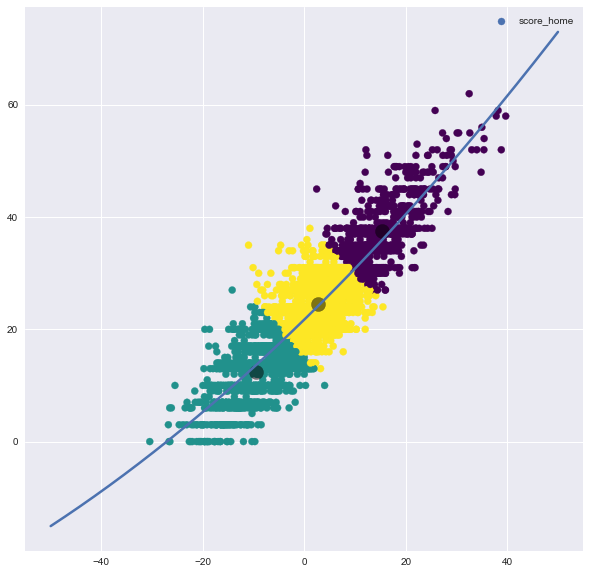

In [8]:
plt.figure(figsize = (10,10))
plt.scatter(cluster_df.home_variance, cluster_df.score_home, c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)
poly_model = make_pipeline(PolynomialFeatures(),
                               LinearRegression())
poly_model.fit(X.home_variance[:, np.newaxis], X.score_home)
xfit = np.linspace(-50,50, 10000)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.plot(xfit, yfit,linewidth=2.5)
plt.legend(loc = 'best');

# CLUSTER - SUNDAY

In [24]:
cluster_df = week5_df[['over_under_result','spread_favorite','home_favorite','last_four_difference','exp_win_difference','score_home','home_losses', 'spread_favorite','away_exp_win_pct','away_pt_diff_pg','weather_wind_mph','away_win_pct_last_4','h_ppg','a_ppg','home_exp_win_pct','home_pt_diff_pg','home_favorite','home_win_pct_last_4', 'over_under_line','total_ppg','total_points_against','weather_humidity','point_total','weather_temperature','schedule_season','a_papg','h_papg']]
cluster_df['per_game_difference'] = (cluster_df.h_ppg - cluster_df.a_ppg)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [25]:
X = cluster_df[['total_points_against','total_ppg']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
cluster_df['cluster'] = y_kmeans
print(len(y_kmeans[(y_kmeans == 0)]))
print(len(y_kmeans[(y_kmeans == 1)]))
print(len(y_kmeans[(y_kmeans == 2)]))
print(len(y_kmeans[(y_kmeans == 3)]))
print(len(y_kmeans[(y_kmeans == 4)]))
print(kmeans.cluster_centers_)
centers = kmeans.cluster_centers_

763
865
640
842
0
[[49.83205767 37.35408912]
 [38.80647399 39.56782659]
 [38.40834375 51.64354687]
 [47.83247031 48.47957245]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [26]:
from plotly import __version__
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
print (__version__) # requires version >= 1.9.0

#Always run this the command before at the start of notebook
init_notebook_mode(connected=True)
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    z=cluster_df.spread_favorite,
    x=cluster_df.total_points_against,
    y=cluster_df.total_ppg,
    mode='markers',
    marker=dict(
        size=8,
        color=y_kmeans,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    ))


trace2 = go.Scatter3d(
    x=centers[:, 0],
    y=centers[:, 1],
    z=centers[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color='black',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.3
    )
)

data = [trace1,trace2]
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='Total PAPG'),
                    yaxis = dict(
                        title='Total PPG'),
                    zaxis = dict(
                        title='Spread'),),
                    width=700,
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10)
                  )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

3.0.0


ValueError: 
    Invalid value of type 'pandas.core.frame.DataFrame' received for the 'z' property of scatter3d
        Received value:       spread_favorite  spread_favorite
5431             -2.5             -2.5
5432             -3.0             -3.0
5433             -5.0             -5.0
5434             -6.0             -6.0
5435             -1.5             -1.5
5436             -6.5             -6.5
5437            -13.5            -13.5
5438             -3.0             -3.0
5439             -3.0             -3.0
5440             -3.0             -3.0
5441             -3.0             -3.0
5442             -6.0             -6.0
5443             -3.5             -3.5
5444             -1.0             -1.0
5445             -6.5             -6.5
5446             -2.0             -2.0
5447             -3.5             -3.5
5448             -7.0             -7.0
5449             -6.5             -6.5
5450             -4.5             -4.5
5451             -4.5             -4.5
5452             -6.0             -6.0
5453             -3.0             -3.0
5454             -7.0             -7.0
5455             -7.5             -7.5
5456             -1.5             -1.5
5457             -1.5             -1.5
5458             -3.0             -3.0
5459             -3.5             -3.5
5460             -4.0             -4.0
...               ...              ...
9602             -3.0             -3.0
9603            -10.0            -10.0
9604             -5.5             -5.5
9605             -3.5             -3.5
9606             -4.5             -4.5
9607            -11.0            -11.0
9608            -11.0            -11.0
9609             -5.5             -5.5
9610             -7.5             -7.5
9611             -4.0             -4.0
9612             -5.5             -5.5
9613             -3.0             -3.0
9614             -8.0             -8.0
9615            -10.0            -10.0
9616             -5.0             -5.0
9617             -8.0             -8.0
9618             -3.0             -3.0
9619             -7.5             -7.5
9620             -5.5             -5.5
9621             -7.0             -7.0
9622             -6.0             -6.0
9623             -2.5             -2.5
9624            -13.5            -13.5
9625            -17.0            -17.0
9626             -4.5             -4.5
9627             -3.5             -3.5
9628             -5.0             -5.0
9629             -8.0             -8.0
9630             -6.0             -6.0
9631             -2.5             -2.5

[3110 rows x 2 columns]

    The 'z' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [27]:
#cluster_df

Text(0,0.5,'Defense')

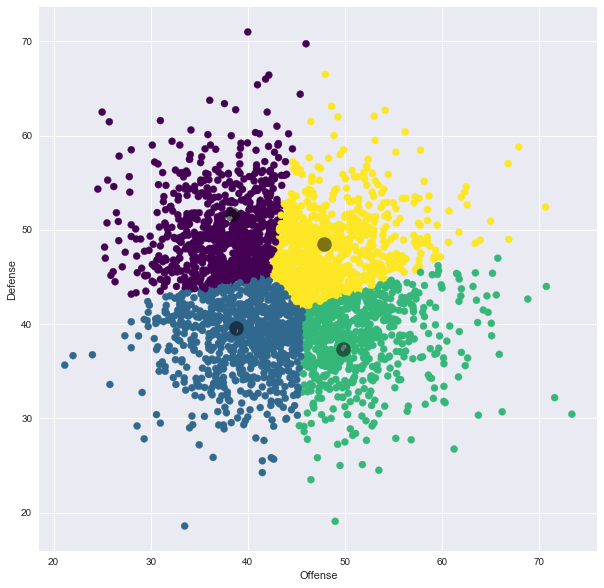

In [28]:
plt.figure(figsize = (10,10))
plt.scatter(cluster_df.total_ppg,cluster_df.total_points_against, c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0],centers[:,1], c='black', s=200, alpha=0.5)
plt.xlabel('Offense')
plt.ylabel('Defense')

In [31]:
good_o_bad_d = cluster_df[cluster_df.cluster==2]
good_o_good_d = cluster_df[cluster_df.cluster==3]
bad_o_bad_d = cluster_df[cluster_df.cluster==1]
bad_o_good_d = cluster_df[cluster_df.cluster==0]

In [32]:
cluster_df

,over_under_result,spread_favorite,home_favorite,last_four_difference,exp_win_difference,score_home,home_losses,spread_favorite,away_exp_win_pct,away_pt_diff_pg,...,total_ppg,total_points_against,weather_humidity,point_total,weather_temperature,schedule_season,a_papg,h_papg,per_game_difference,cluster
5431,0,-2.5,1,-0.50,-0.106576,6,2,-2.5,0.988403,14.750,...,52.17,29.75,66.552,26,72.0,2002,11.75,18.00,-0.83,2
5432,1,-3.0,0,-0.25,-0.469109,31,2,-3.0,0.981043,18.000,...,70.67,52.42,69.000,80,55.0,2002,19.67,32.75,-4.67,3
5433,0,-5.0,1,0.25,0.282943,13,1,-5.0,0.652895,2.250,...,39.75,29.75,72.000,29,71.0,2002,18.50,11.25,-1.75,1
5434,1,-6.0,1,0.25,0.533319,21,2,-6.0,0.139544,-5.667,...,39.42,42.08,68.000,47,57.0,2002,19.33,22.75,12.08,1
5435,1,-1.5,0,0.00,-0.217037,17,2,-1.5,0.316216,-2.250,...,28.00,37.50,55.000,38,78.0,2002,16.00,21.50,0.50,1
5436,0,-6.5,1,-0.25,-0.330077,26,1,-6.5,0.994859,16.000,...,50.00,31.25,43.000,35,53.0,2002,9.50,21.75,-1.00,2
5437,1,-13.5,1,0.50,0.810391,28,1,-13.5,0.000151,-24.000,...,27.08,46.08,66.552,49,72.0,2002,29.75,16.33,15.58,0
5438,1,-3.0,0,-0.25,-0.054563,28,1,-3.0,0.990207,19.000,...,60.33,31.67,79.000,53,81.0,2002,16.00,15.67,-9.67,2
5439,0,-3.0,1,0.00,-0.017698,26,1,-3.0,0.944540,12.250,...,64.75,41.25,78.000,39,82.0,2002,20.00,21.25,0.25,2
5440,1,-3.0,1,0.50,0.704727,32,1,-3.0,0.080456,-8.667,...,43.42,46.58,66.552,61,72.0,2002,24.33,22.25,12.08,3


In [33]:
centers

array([[49.83205767, 37.35408912],
       [38.80647399, 39.56782659],
       [38.40834375, 51.64354687],
       [47.83247031, 48.47957245]])

In [34]:
cluster_df.to_csv('cluster_df.csv')